In [6]:
import torch
import torch.nn as nn
import torchvision
from torchvision import transforms

from torch.nn import functional as F

import time
import math

import matplotlib.pyplot as plt

from torch.utils.data import TensorDataset, DataLoader

import numpy as np

In [7]:
device = "cpu"

In [8]:
def plot_decision_boundary(model, X, y, save_file_name=""):
    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.02),
                         np.arange(y_min, y_max, 0.02))

    grid = np.c_[xx.ravel(), yy.ravel()]

    with torch.no_grad():
        model.eval()
        output = model(torch.from_numpy(grid).float())
        preds = (output > 0.5).float()
        

    Z = preds.reshape(xx.shape)

    plt.contourf(xx, yy, Z, cmap=plt.cm.Spectral)
    plt.scatter(X[:, 0], X[:, 1], c=y[:], cmap=plt.cm.Spectral)

    # save to file
    if len(save_file_name) > 0:
        plt.savefig(save_file_name,bbox_inches='tight')

    plt.show()

In [13]:
class QuasiPolySynapse(nn.Module):
    def __init__(self, exponential_terms=3):
        super().__init__()
        power_initial_value = 2
        self.power = nn.Parameter(torch.tensor([power_initial_value], dtype=torch.float32), requires_grad=False)
        self.term_weights = nn.Parameter(torch.full((exponential_terms,), 0.5), requires_grad=True)

        
    def forward(self, x):
        # print(f"x[:, j] is {x.shape}")
        y = self.term_weights[0] * x ** self.power
        for i in range(1, int(math.floor(self.power)-1)):
            y = y + self.term_weights[i] * x ** i
        
        return y
    
    def __repr__(self):
        return f'QuasiPolySynapse(power={self.power}, term_weights={self.term_weights})'


class QuasiPolyLayer(nn.Module):
  def __init__(self, in_features, out_features, product=False):
    super().__init__()
    self.out_features = out_features
    self.in_features = in_features
    self.bias_before = nn.Parameter(torch.Tensor([-0.5,-0.55]), requires_grad=True)
    # a 2d module list of quasipoly synapses sizes in_features x out_features
    self.synapses = nn.ModuleList([nn.ModuleList([QuasiPolySynapse(3) for _ in range(self.in_features)]) for _ in range(self.out_features)])
    self.bias = nn.Parameter(torch.full((out_features,), -0.9), requires_grad=True) # the radius
    self.product = product
  
  def forward(self, x): # x is a batch of inputs

    # print(f"main x size is {x.size()} ")

    y = torch.zeros(x.shape[0], self.out_features, dtype=torch.float32)

    y = y.to(device)

    x = x + self.bias_before
    
    # apply synapses to inputs
    for i in range(self.out_features):
        # print(f"synapse {i}")
        if self.product:
            y[:, i] = 1
        else:
            y[:, i] = 0

        for j in range(self.in_features):
            # print(f"y size is {y.size()} and x size is {x.size()}")
            # print(f"y size is {y.shape} and x size is {x.shape}")
            if self.product:
                y[:, i] = y[:, i].clone() * self.synapses[i][j](x[:, j])
            else:
                y[:, i] = y[:, i] + self.synapses[i][j](x[:, j])

    # add bias
    y = y + self.bias

    y = y * -1

    # print(f"y is {y} ")

    return y
  
  def __repr__(self):
    return f'QuasiPolyLayer(in_features={self.in_features}, out_features={self.out_features}, product={self.product}, bias_before={self.bias_before}, synapses={self.synapses}, bias={self.bias})'


In [10]:
# read the data from the "GeneratorInput.txt" file
def read_data(file_name):
    with open(file_name, 'r') as file:
        data = file.readlines()
    return data

raw_data = read_data("GeneratorInput.txt")

datasets = []
y_idx = 0
dataset = None
for line in raw_data:
    if len(line) <= 1:
        datasets.append(dataset.copy())
        y_idx = 0
        dataset = []
        continue
    y_idx += 1
    if dataset is None:
        dataset = []
    for x_idx,char in enumerate(line):
        if char == '0' or char == '1':
            dataset.append((y_idx,x_idx+1, int(char)))
    

datasets

[[(1, 2, 0),
  (2, 1, 0),
  (2, 2, 0),
  (2, 5, 1),
  (2, 9, 0),
  (2, 10, 0),
  (3, 1, 0),
  (3, 5, 1),
  (3, 8, 1),
  (4, 4, 1),
  (4, 5, 1),
  (4, 6, 1),
  (4, 7, 1),
  (4, 8, 1),
  (5, 2, 1),
  (5, 3, 1),
  (5, 7, 1),
  (6, 4, 1),
  (6, 6, 1),
  (7, 4, 1),
  (7, 8, 1),
  (7, 9, 1),
  (8, 3, 1),
  (8, 5, 1),
  (8, 6, 1),
  (8, 7, 1),
  (8, 8, 1),
  (8, 10, 0),
  (9, 1, 0),
  (9, 2, 0),
  (9, 5, 1),
  (9, 7, 1),
  (10, 1, 0),
  (10, 2, 0),
  (10, 8, 0),
  (10, 9, 0),
  (10, 10, 0)],
 [(1, 3, 1),
  (1, 8, 1),
  (1, 9, 1),
  (2, 1, 0),
  (2, 5, 1),
  (2, 6, 1),
  (2, 7, 1),
  (2, 10, 1),
  (3, 4, 1),
  (3, 8, 1),
  (3, 9, 1),
  (3, 10, 1),
  (4, 1, 0),
  (4, 2, 0),
  (4, 6, 1),
  (4, 7, 1),
  (5, 1, 0),
  (5, 7, 1),
  (5, 9, 1),
  (6, 6, 1),
  (6, 10, 1),
  (7, 1, 0),
  (7, 3, 0),
  (7, 5, 0),
  (7, 7, 1),
  (7, 8, 1),
  (7, 9, 1),
  (7, 10, 1),
  (8, 1, 0),
  (8, 2, 0),
  (8, 4, 0),
  (8, 6, 0),
  (9, 1, 0),
  (9, 2, 0),
  (9, 4, 0),
  (9, 5, 0),
  (9, 6, 0),
  (9, 8, 0),
  (10, 1, 0)

In [11]:
data = datasets[0]
X = torch.tensor([list(sublist[:2]) for sublist in data], dtype=torch.float32)
y = torch.tensor([item for sublist in data for item in sublist[2:]], dtype=torch.float32).unsqueeze(1)


#scale the data to be between 0 and 1
X = X / X.max()



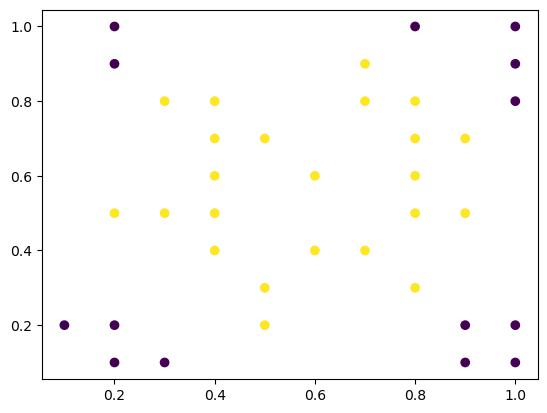

In [12]:
plt.scatter(X[:,0], X[:,1], c=y)
plt.show()


In [14]:
# Create a PyTorch dataset and data loader
dataset = TensorDataset(X, y)
dataloader = DataLoader(dataset, batch_size=4, shuffle=True)

class Network2(nn.Module):
    def __init__(self):
        super(Network2, self).__init__()
        self.polynomial = QuasiPolyLayer(2, 1)
        # self.product = QuasiPolyLayer(2, 1, product=True)
        self.sigmoid = nn.Sigmoid()


    def forward(self, x):
        out = self.sigmoid( self.polynomial(x))
        return out

model = Network2()
criterion = nn.BCELoss()
optimizer = torch.optim.SGD(model.parameters(),lr=0.005)
# optimizer = torch.optim.Adam(model.parameters(), lr=0.001)


Epoch [1/2], Loss: 0.3515, Accuracy: 62.16
Epoch [2/2], Loss: 1.1632, Accuracy: 62.16


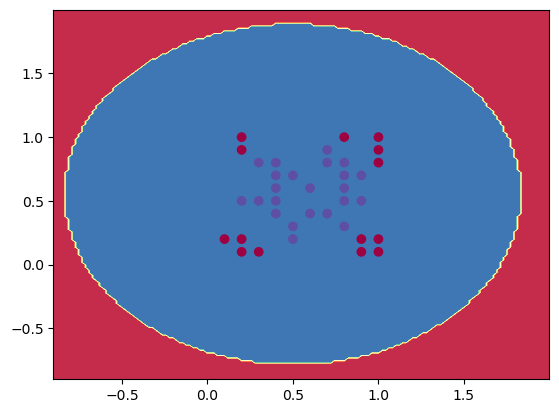

In [15]:

# Train the model
num_epochs = 2
for epoch in range(num_epochs):
    for X_batch, y_batch in dataloader:
        
        y_pred = model(X_batch)
        # print(f"y_pred is {y_pred} and y_batch is {y_batch}")
        loss = criterion(y_pred, y_batch)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    # calculate accuracy for all training data
    y_pred = model(X)
    y_pred = torch.round(y_pred)
    correct = (y_pred == y).sum().item()
    accuracy = correct / len(y)
    

    # if (epoch + 1) % 20 == 0:
    print(f"Epoch [{epoch + 1}/{num_epochs}], Loss: {loss:.4f}, Accuracy: {accuracy * 100:.2f}")
    

plot_decision_boundary(model, X, y)

In [108]:
# print all parameters of the model
for name, param in model.named_parameters():
    print(f"{name} has shape {param.shape} and value {param}")


polynomial.bias_before has shape torch.Size([2]) and value Parameter containing:
tensor([-1.0203, -0.7561], requires_grad=True)
polynomial.bias has shape torch.Size([1]) and value Parameter containing:
tensor([0.5173], requires_grad=True)
polynomial.synapses.0.0.power has shape torch.Size([1]) and value Parameter containing:
tensor([2.])
polynomial.synapses.0.0.term_weights has shape torch.Size([3]) and value Parameter containing:
tensor([ 0.0625,  0.3320, -1.1633], requires_grad=True)
polynomial.synapses.0.1.power has shape torch.Size([1]) and value Parameter containing:
tensor([2.])
polynomial.synapses.0.1.term_weights has shape torch.Size([3]) and value Parameter containing:
tensor([-1.4820,  0.6824,  1.0766], requires_grad=True)
